# Построение прототипа книжного рекомендательного сервиса

## 1: базовые модели
## 2: гибридная система



# Импорты и настройки

In [1]:
# Первый запуск в новой сессии + Restart runtime

!pip -q uninstall -y scikit-surprise surprise numpy
!pip -q install numpy==1.26.4
!pip -q install --no-cache-dir scikit-surprise implicit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 127.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
shap 0.50.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
tobler 0.13.0 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
rasterio 1.5.0 requires numpy>=2

Restart runtime!

In [2]:
# Проверяем
import numpy as np
print("NumPy:", np.__version__)

import surprise
print("surprise:", surprise.__version__)

import implicit
print("implicit:", implicit.__version__)

NumPy: 1.26.4
surprise: 1.1.4
implicit: 0.7.2


In [3]:
# Импорты
import numpy as np
import pandas as pd

from pathlib import Path
from dataclasses import dataclass

from scipy.sparse import csr_matrix

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler, normalize

# Matrix Factorization (explicit)
from surprise import Dataset as SurpriseDataset, Reader, SVD, accuracy

# Matrix Factorization (implicit)
from implicit.als import AlternatingLeastSquares

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm
import time

# Нейросеть
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

In [4]:
# настройки
RANDOM_STATE = 42
TOP_K = 10
RELEVANCE_THRESHOLD = 4
np.random.seed(RANDOM_STATE)
user_num = 150  # номер произвольного пользоваителя для демо

# Загрузка данных

In [5]:
!git clone https://github.com/zygmuntz/goodbooks-10k.git 2>/dev/null || echo " Данные загружены"

ratings = pd.read_csv('goodbooks-10k/ratings.csv')
books = pd.read_csv('goodbooks-10k/books.csv')
book_tags = pd.read_csv('goodbooks-10k/book_tags.csv')
tags = pd.read_csv('goodbooks-10k/tags.csv')

print(f"Ratings: {ratings.shape}")
print(f"Books: {books.shape}")
print(f"Book Tags: {book_tags.shape}")
print(f"Tags: {tags.shape}")

Ratings: (5976479, 3)
Books: (10000, 23)
Book Tags: (999912, 3)
Tags: (34252, 2)


# EDA

## Связь датасетов

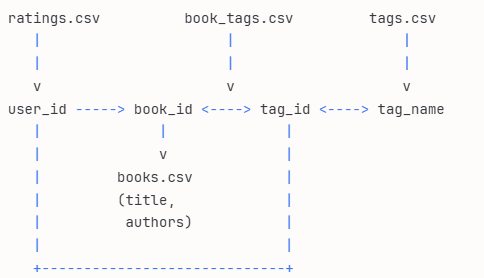

In [6]:
print("RATINGS")
display(ratings.head())
print("\n")
ratings.info()
print("\n")
print(ratings.describe())

RATINGS


,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5976479 entries, 0 to 5976478
Data columns (total 3 columns):
 #   Column   Dtype
---  ------   -----
 0   user_id  int64
 1   book_id  int64
 2   rating   int64
dtypes: int64(3)
memory usage: 136.8 MB


            user_id       book_id        rating
count  5.976479e+06  5.976479e+06  5.976479e+06
mean   2.622446e+04  2.006477e+03  3.919866e+00
std    1.541323e+04  2.468499e+03  9.910868e-01
min    1.000000e+00  1.000000e+00  1.000000e+00
25%    1.281300e+04  1.980000e+02  3.000000e+00
50%    2.593800e+04  8.850000e+02  4.000000e+00
75%    3.950900e+04  2.973000e+03  5.000000e+00
max    5.342400e+04  1.000000e+04  5.000000e+00


In [7]:
# проверим, есть ли пользователи, поставившие одной книге более одной оценки
duplicates = ratings.groupby(['user_id', 'book_id']).size().reset_index(name='count')
duplicates = duplicates[duplicates['count'] > 1]

if not duplicates.empty:
    print(f" Найдено {len(duplicates)} пар (user_id, book_id) с несколькими оценками.")
    display(duplicates.head(10))
else:
    print(" Все пары (user_id, book_id) уникальны — дубликатов нет.")

 Все пары (user_id, book_id) уникальны — дубликатов нет.


### Распределение оценок

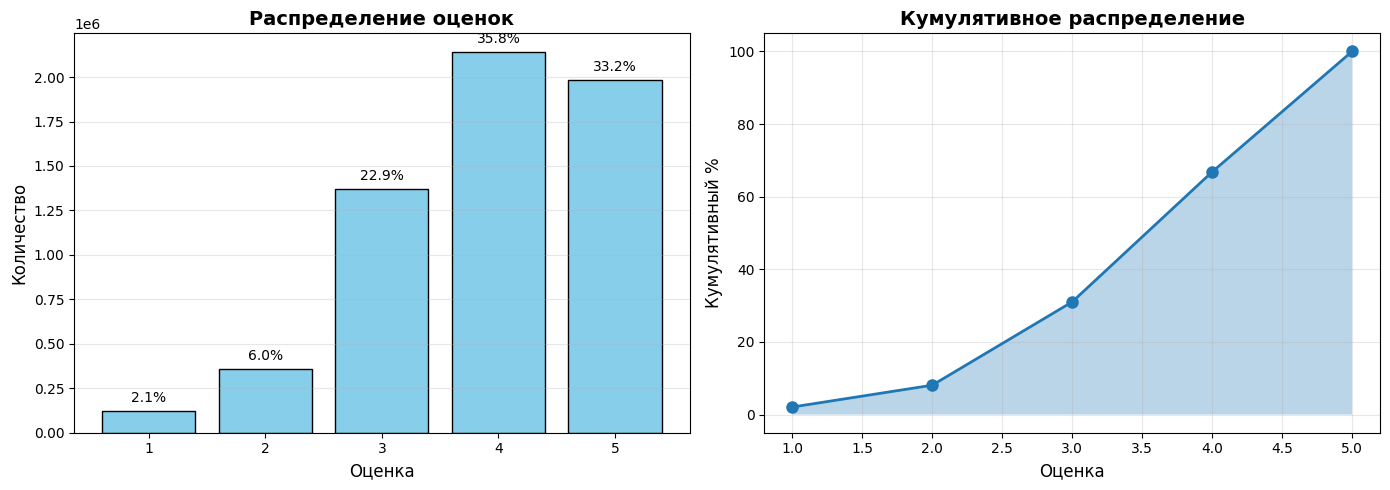


 Средняя оценка: 3.92
Медиана: 4
 Std: 0.99

 Смещение к высоким оценкам. 69.0% >= 4


In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

rating_counts = ratings['rating'].value_counts().sort_index()

axes[0].bar(rating_counts.index, rating_counts.values, color='skyblue', edgecolor='black')
axes[0].set_xlabel('Оценка', fontsize=12)
axes[0].set_ylabel('Количество', fontsize=12)
axes[0].set_title('Распределение оценок', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

total = len(ratings)
for i, v in enumerate(rating_counts.values):
    axes[0].text(rating_counts.index[i], v + 50000, f'{v/total*100:.1f}%', ha='center')

cumulative = rating_counts.cumsum() / rating_counts.sum() * 100
axes[1].plot(cumulative.index, cumulative.values, marker='o', linewidth=2, markersize=8)
axes[1].fill_between(cumulative.index, cumulative.values, alpha=0.3)
axes[1].set_xlabel('Оценка', fontsize=12)
axes[1].set_ylabel('Кумулятивный %', fontsize=12)
axes[1].set_title('Кумулятивное распределение', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n Средняя оценка: {ratings['rating'].mean():.2f}")
print(f"Медиана: {ratings['rating'].median():.0f}")
print(f" Std: {ratings['rating'].std():.2f}")
print(f"\n Смещение к высоким оценкам. {(ratings['rating'] >= 4).sum() / len(ratings) * 100:.1f}% >= 4")

Пользователи склонны ставить высокие оценки и в целом лояльны.
Только 31% оценок 3 и ниже, 69% - 4 и выше. Это свидетельствует
о том, что пользователи склонны оценивать только понравившиеся книги.

Это может повлиять на модель, которая будет лучше предсказывать
высокие оценки и недооценивать негативные предпочтения.

In [9]:
print("BOOKS")
display(books.head())
print("\n")
books.info()
print("\n")

BOOKS


,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   book_id                    10000 non-null  int64  
 1   goodreads_book_id          10000 non-null  int64  
 2   best_book_id               10000 non-null  int64  
 3   work_id                    10000 non-null  int64  
 4   books_count                10000 non-null  int64  
 5   isbn                       9300 non-null   object 
 6   isbn13                     9415 non-null   float64
 7   authors                    10000 non-null  object 
 8   original_publication_year  9979 non-null   float64
 9   original_title             9415 non-null   object 
 10  title                      10000 non-null  object 
 11  language_code              8916 non-null   object 
 12  average_rating             10000 non-null  float64
 13  ratings_count              10000 non-null  in

В столбце original_title - пропуски, заполним их значениями из столбца title

In [10]:
books['original_title'] = books['original_title'].fillna(books['title'])

### Активность пользователей

Статистика активности пользователей:


,num_ratings
count,53424.000000
mean,111.868804
std,26.071224
min,19.000000
25%,96.000000
50%,111.000000
75%,128.000000
max,200.000000


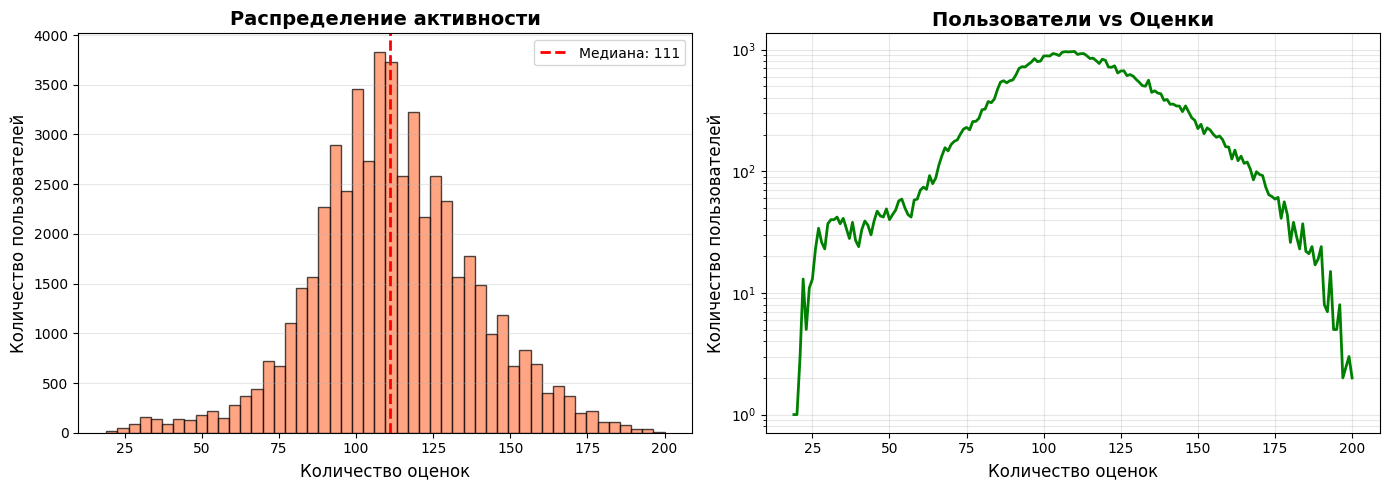


 Холодный старт: 0 (0.0%) пользователей <10 оценок
 Активные: 52525 (98.3%) пользователей >=50 оценок


In [11]:
user_activity = ratings.groupby('user_id').size().reset_index(name='num_ratings')

print("Статистика активности пользователей:")
display(user_activity['num_ratings'].describe())

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# гистограмма
axes[0].hist(user_activity['num_ratings'], bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Количество оценок', fontsize=12)
axes[0].set_ylabel('Количество пользователей', fontsize=12)
axes[0].set_title('Распределение активности', fontsize=14, fontweight='bold')
axes[0].axvline(user_activity['num_ratings'].median(), color='red',
               linestyle='--', linewidth=2, label=f"Медиана: {user_activity['num_ratings'].median():.0f}")
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# зависимость
rating_dist = user_activity.groupby('num_ratings').size().sort_index()
axes[1].plot(rating_dist.index, rating_dist.values, linewidth=2, color='green')
axes[1].set_xlabel('Количество оценок', fontsize=12)
axes[1].set_ylabel('Количество пользователей', fontsize=12)
axes[1].set_title('Пользователи vs Оценки', fontsize=14, fontweight='bold')
axes[1].set_yscale('log')
axes[1].grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

cold_start = (user_activity['num_ratings'] < 10).sum()
active = (user_activity['num_ratings'] >= 50).sum()

print(f"\n Холодный старт: {cold_start} ({cold_start/len(user_activity)*100:.1f}%) пользователей <10 оценок")
print(f" Активные: {active} ({active/len(user_activity)*100:.1f}%) пользователей >=50 оценок")

Среднее значение выставленных пользователями оценок (111.9) практически
совпадает с медианой распределения (111). Распределение симметричное
(колоколообразная форма), значит поведение пользователей является
предсказуемым и однородным.

Пользователи очень активны (98.3% имеют более 50 оценок), минимальное
количество оценок - 19. Однако в нашем датасете нет ни "новичков"
(отсутствует холодный старт), ни "суперпользователей" с высокой
активностью (>200 оценок).

В реальных системах такой ситуации скорее всего быть не может, и метрики
будут завышены относительно реальных условий. Для корректной оценки будем использовть временное разбиение (первые 80% оценок в train, последние
20% в test), что позволяет симулировать реалистичный сценарий: предсказываем следующую книгу опираясь на исторические данные поведения пользователя.

Пользователи с малым количеством оценок (<10) могут вначале получать популярные рекомендации, а в дальнейшем переходить на персонализированные модели

### Популярность книг

Статистика популярности книг:


,num_ratings
count,10000.000000
mean,597.647900
std,1267.289788
min,8.000000
25%,155.000000
50%,248.000000
75%,503.000000
max,22806.000000


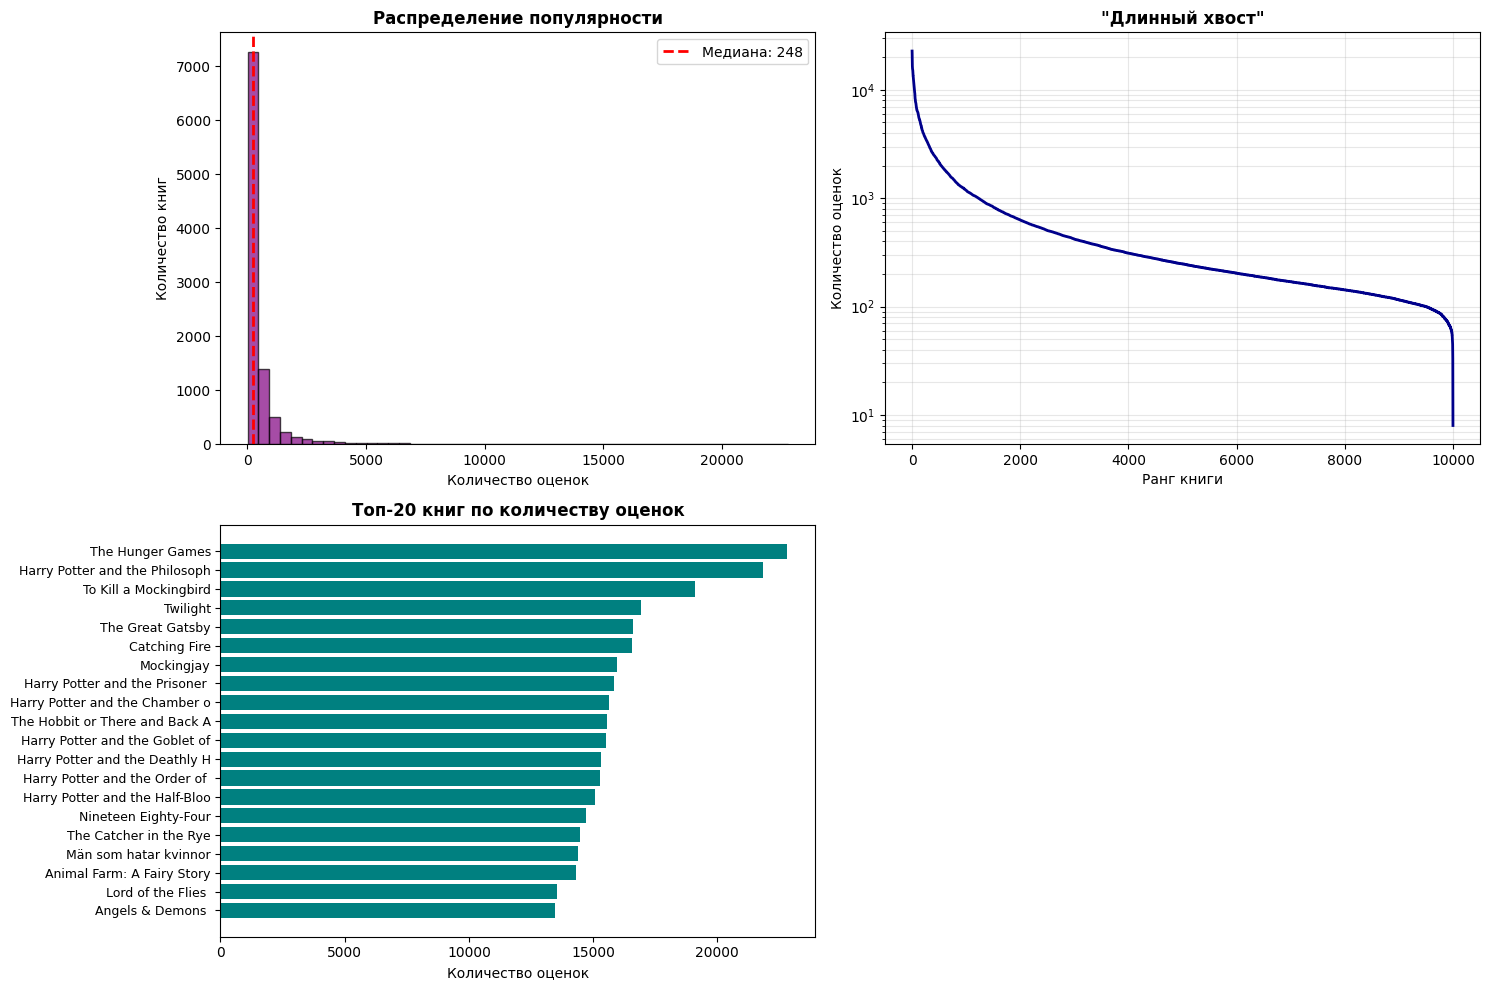


 Длинный хвост: 9 (0.1%) книг < 50 оценок
 Популярные: 2526 (25.3%) книг ≥ 500 оценок


In [12]:
book_pop = ratings.groupby('book_id').agg({'rating': ['count', 'mean']}).reset_index()
book_pop.columns = ['book_id', 'num_ratings', 'avg_rating']

print("Статистика популярности книг:")
display(book_pop['num_ratings'].describe())

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# --- График 1: Распределение ---
axes[0, 0].hist(book_pop['num_ratings'], bins=50, color='purple', edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Количество оценок')
axes[0, 0].set_ylabel('Количество книг')
axes[0, 0].set_title('Распределение популярности', fontweight='bold')
axes[0, 0].axvline(book_pop['num_ratings'].median(), color='red',
                   linestyle='--', linewidth=2, label=f"Медиана: {book_pop['num_ratings'].median():.0f}")
axes[0, 0].legend()

# Длинный хвост
sorted_pop = book_pop.sort_values('num_ratings', ascending=False).reset_index(drop=True)
axes[0, 1].plot(sorted_pop.index, sorted_pop['num_ratings'], linewidth=2, color='darkblue')
axes[0, 1].set_xlabel('Ранг книги')
axes[0, 1].set_ylabel('Количество оценок')
axes[0, 1].set_title('"Длинный хвост"', fontweight='bold')
axes[0, 1].set_yscale('log')
axes[0, 1].grid(True, alpha=0.3, which='both')

# Топ-20 книг
top_20 = book_pop.nlargest(20, 'num_ratings').merge(books[['book_id', 'original_title']], on='book_id', how='left')
top_20['short'] = top_20['original_title'].str[:30]

axes[1, 0].barh(range(20), top_20['num_ratings'], color='teal')
axes[1, 0].set_yticks(range(20))
axes[1, 0].set_yticklabels(top_20['short'], fontsize=9)
axes[1, 0].set_xlabel('Количество оценок')
axes[1, 0].set_title('Топ-20 книг по количеству оценок', fontweight='bold')
axes[1, 0].invert_yaxis()

axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

long_tail = (book_pop['num_ratings'] < 50).sum()
popular = (book_pop['num_ratings'] >= 500).sum()

print(f"\n Длинный хвост: {long_tail} ({long_tail / len(book_pop) * 100:.1f}%) книг < 50 оценок")
print(f" Популярные: {popular} ({popular / len(book_pop) * 100:.1f}%) книг ≥ 500 оценок")


Медианное количество оценок на книгу составляет 248, при этом среднее значение оценок на книгу в 2,4 раза больше — 598. Несколько суперпопулярных книг завышают среднее значение. Например, топ-1 книга имеет 22,806 оценок — в 92 раза больше медианы!

Мы видим, что большинство книг малопопулярны, и только незначительное количество книг обращают на себя внимание пользователей. Мы имеем дело с распределением с правосторонним смещением (right-skewed distribution), которое противоположно нормальному распределению. В целом это типичная ситуация для оценки популярности товаров в рекомендательных системах.

Это создает несколько проблем:

Несбалансированность данных: Для популярных книг много данных — их легко рекомендовать. Для малопопулярных книг данных мало — их сложно рекомендовать корректно. Нишевые интересы будут игнорироваться.

Смещение популярности (Popularity Bias): Модель обучается преимущественно на популярных книгах и может игнорировать релевантные, но непопулярные книги, что снижает разнообразие рекомендаций.

Разреженность матрицы: Матрица user-item будет сильно разреженной, так как для большинства книг очень мало оценок. Это затрудняет работу collaborative filtering методов."

In [13]:
print("TAGS")
display( tags.head())
print("\n")
display( tags.tail())
print("\n")
tags.info()

TAGS


,tag_id,tag_name
0,0,-
1,1,--1-
2,2,--10-
3,3,--12-
4,4,--122-


,tag_id,tag_name
34247,34247,Ｃhildrens
34248,34248,Ｆａｖｏｒｉｔｅｓ
34249,34249,Ｍａｎｇａ
34250,34250,ＳＥＲＩＥＳ
34251,34251,ｆａｖｏｕｒｉｔｅｓ




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34252 entries, 0 to 34251
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tag_id    34252 non-null  int64 
 1   tag_name  34252 non-null  object
dtypes: int64(1), object(1)
memory usage: 535.3+ KB


## Анализ тегов

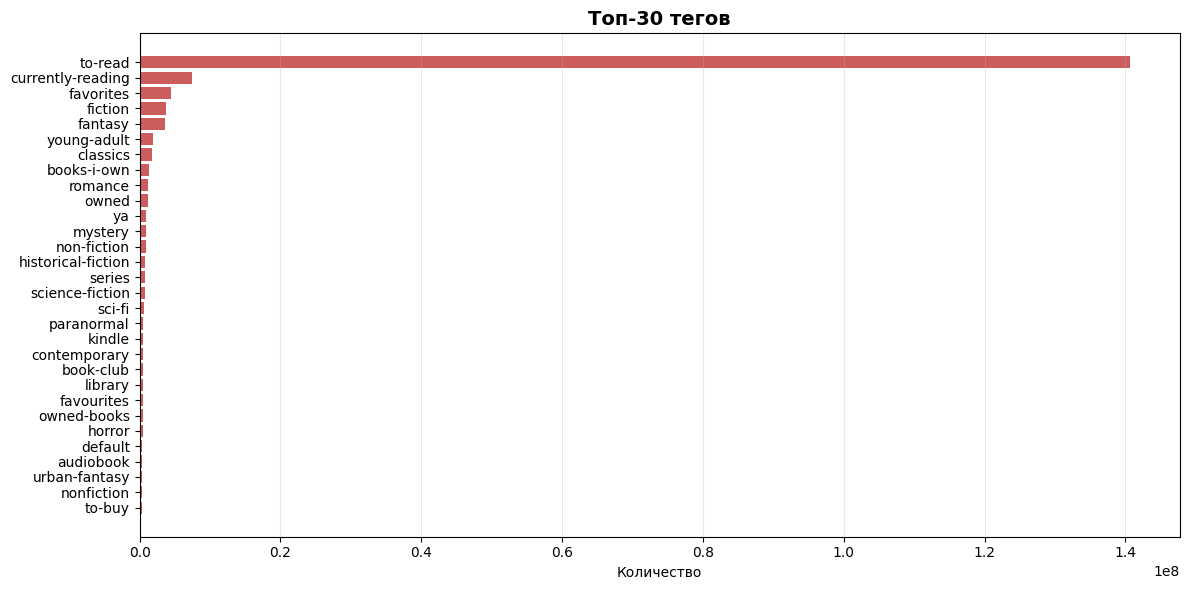


  Всего тегов: 34252
 Среднее тегов на книгу: 100.0
 Топ-5: to-read, currently-reading, favorites, fiction, fantasy


In [14]:
book_tags_named = book_tags.merge(tags, on='tag_id')
top_tags = (
    book_tags_named
    .groupby('tag_name')['count']
    .sum()
    .sort_values(ascending=False)
    .head(30)
)

plt.figure(figsize=(12, 6))
plt.barh(range(30), top_tags.values, color='indianred')
plt.yticks(range(30), top_tags.index, fontsize=10)
plt.xlabel('Количество')
plt.title('Топ-30 тегов', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

tags_per_book = book_tags.groupby('goodreads_book_id').size()

print(f"\n  Всего тегов: {len(tags)}")
print(f" Среднее тегов на книгу: {tags_per_book.mean():.1f}")
print(f" Топ-5: {', '.join(top_tags.head(5).index)}")

Видно, что среди тегов присутствует те, что не имеют отношение к контенту.Например "to-read" - пользователь планирует прочитать / читает, "audiobook", "to-buy". Если выделить только контентные теги, то модель TF-IDF сфокусируется на реальных жанрах, улучшиться метрики Precision@K.

# Подготовка контентных профилей книг (title + tags)

In [15]:
def build_book_profiles(books: pd.DataFrame, tags: pd.DataFrame, book_tags: pd.DataFrame, top_tags_per_book: int = 20) -> pd.DataFrame:
    bt = book_tags.merge(tags, on='tag_id', how='left')
    bt = bt.sort_values(['goodreads_book_id', 'count'], ascending=[True, False])
    bt = bt.groupby('goodreads_book_id').head(top_tags_per_book)

    tag_str = bt.groupby('goodreads_book_id')['tag_name'].apply(lambda x: ' '.join(map(str, x))).reset_index()
    out = books.merge(tag_str, on='goodreads_book_id', how='left')

    out['tag_name'] = out['tag_name'].fillna('')
    out['title_text'] = out['original_title'].fillna('')
    out['profile'] = (out['title_text'] + ' ' + out['tag_name']).str.strip()
    return out[['book_id', 'profile']]

book_profiles = build_book_profiles(books, tags, book_tags, top_tags_per_book=20)
book_profiles.head()


,book_id,profile
0,1,The Hunger Games favorites currently-reading y...
1,2,Harry Potter and the Philosopher's Stone to-re...
2,3,Twilight young-adult fantasy favorites vampire...
3,4,To Kill a Mockingbird classics favorites to-re...
4,5,The Great Gatsby classics favorites fiction cl...


В данных нет времени выставления оценок (timestamp), поэтому "временной" split построить нельзя. Предположение, что порядок строк (или book_id) соответствует времени - сильное искусственное допущение.

Поэтому сделаем per-user random holdout: внутри каждого пользователя перемешиваем его оценки и берём 80/20.

Релевантность зададим на этапе метрик (rating >= 4).

In [16]:
def split_by_user(
    ratings_df: pd.DataFrame,
    train_ratio: float = 0.8,
    random_state: int = 42
):
    if not 0 < train_ratio < 1:
        raise ValueError("train_ratio должен быть в (0, 1).")

    df = ratings_df[['user_id', 'book_id', 'rating']].copy().reset_index(drop=True)
    rng = np.random.default_rng(random_state)

    train_parts, test_parts = [], []

    user_counts = df['user_id'].value_counts()
    n_train = (user_counts * train_ratio).astype(int).clip(lower=1)

    for uid, grp in df.groupby('user_id', sort=False):
        idx = np.arange(len(grp))
        rng.shuffle(idx)
        grp = grp.iloc[idx].reset_index(drop=True)

        t = int(n_train.loc[uid])
        train_parts.append(grp.iloc[:t])
        test_parts.append(grp.iloc[t:])

    train_df = pd.concat(train_parts, ignore_index=True)
    test_df = pd.concat(test_parts, ignore_index=True)

    total = len(df)
    total_users = user_counts.size
    one_rating_users = int((user_counts == 1).sum())

    print(f" Train: {len(train_df):,} оценок ({len(train_df)/total*100:.1f}%)")
    print(f" Test:  {len(test_df):,} оценок ({len(test_df)/total*100:.1f}%)")
    print(f"\n Всего пользователей: {total_users:,}")
    print(f" Пользователи с 1 оценкой (test пуст): {one_rating_users} ({one_rating_users/total_users*100:.1f}%)")

    # Проверка утечки
    train_pairs = set(zip(train_df['user_id'].to_numpy(), train_df['book_id'].to_numpy()))
    test_pairs = set(zip(test_df['user_id'].to_numpy(), test_df['book_id'].to_numpy()))
    if train_pairs & test_pairs:
        raise ValueError("Утечка данных: (user_id, book_id) есть и в train, и в test.")
    print(" Random split: утечки данных нет (проверено по (user_id, book_id)).")

    return train_df, test_df

train_ratings, test_ratings = split_by_user(ratings, train_ratio=0.8, random_state=RANDOM_STATE)

 Train: 4,759,759 оценок (79.6%)
 Test:  1,216,720 оценок (20.4%)

 Всего пользователей: 53,424
 Пользователи с 1 оценкой (test пуст): 0 (0.0%)
 Random split: утечки данных нет (проверено по (user_id, book_id)).


# Метрики

##precision@10

Доля релевантных книг среди первых 10 рекомендаций модели.
Показывает, насколько “точными” являются рекомендации в топе.

###recall@10

Доля релевантных книг пользователя, которые попали в первые 10 рекомендаций.
Характеризует способность модели находить все интересные пользователю книги.

###ndcg@10 (Normalized Discounted Cumulative Gain)

Метрика качества ранжирования, учитывающая позиции релевантных книг в топ-10
(чем выше позиция релевантной книги, тем больший вклад в метрику).

###hitrate@10

Доля пользователей, у которых хотя бы одна релевантная книга присутствует в топ-10 рекомендаций.
Отражает вероятность “попадания” модели хотя бы в один интерес пользователя.

###coverage

Доля уникальных книг каталога, которые были рекомендованы хотя бы одному пользователю.
Показывает разнообразие и широту охвата рекомендаций модели.



In [17]:
def evaluate_recommender(model, test_df, train_df, all_items, k=TOP_K, threshold=RELEVANCE_THRESHOLD, users_iter=None):
    # релевантные в test
    test_rel = (
        test_df[test_df['rating'] >= threshold]
        .groupby('user_id')['book_id']
        .apply(set)
        .to_dict()
    )

    # просмотренные в train
    seen = (
        train_df.groupby('user_id')['book_id']
        .apply(set)
        .to_dict()
    )

    pop = train_df.groupby('book_id').size().to_dict()

    precision_sum = recall_sum = ndcg_sum = hitrate_sum = arp_sum = 0.0
    coverage_set = set()
    users_eval = 0

    # если users_iter не передали — идём по test_rel
    iterator = users_iter if users_iter is not None else test_rel.keys()

    for uid in iterator:
        rel_set = test_rel.get(uid)
        if not rel_set:   # нет релевантных в test - пропускаем
            continue

        seen_items = seen.get(uid, set())
        recs = model.recommend(uid, seen_items=seen_items, k=k)
        if not recs:
            continue

        hits = [1 if b in rel_set else 0 for b in recs]
        h = float(sum(hits))

        precision_sum += h / k
        recall_sum += h / max(1, len(rel_set))
        hitrate_sum += 1.0 if h > 0 else 0.0

        dcg = sum(hit / np.log2(i + 2) for i, hit in enumerate(hits))
        idcg = sum(1.0 / np.log2(i + 2) for i in range(min(len(rel_set), k)))
        ndcg_sum += (dcg / idcg) if idcg > 0 else 0.0

        arp_sum += float(np.mean([pop.get(b, 0) for b in recs]))

        coverage_set.update(recs)
        users_eval += 1

    if users_eval == 0:
        return {
            f'precision@{k}': 0.0,
            f'recall@{k}': 0.0,
            f'ndcg@{k}': 0.0,
            f'hitrate@{k}': 0.0,
            'coverage': 0.0
        }

    return {
        f'precision@{k}': precision_sum / users_eval,
        f'recall@{k}': recall_sum / users_eval,
        f'ndcg@{k}': ndcg_sum / users_eval,
        f'hitrate@{k}': hitrate_sum / users_eval,
        'coverage': len(coverage_set) / max(1, len(all_items))
    }

# Интерфейс моделей (fit / recommend)

In [18]:
@dataclass
class ALSConfig:
    factors: int = 64
    iterations: int = 20
    regularization: float = 0.1
    alpha: float = 1.0

@dataclass
class HybridWeights:
    svd: float = 0.5
    als: float = 0.3
    content: float = 0.2


In [19]:
class BaseRecommender:
    def fit(self, train_df: pd.DataFrame):
        return self

    def recommend(self, user_id: int, seen_items: set, k: int = TOP_K):
        raise NotImplementedError


# Выбор пользователя и вывод рекомендаций (для демонстрации рабоиты моделей)

In [20]:
# Выбор пользователя и seen_items
def find_user_and_seen(train_df, user_row=150):
    user_id = train_df['user_id'].iloc[user_row]
    seen_items = set(train_df.loc[train_df.user_id == user_id, 'book_id'])
    return int(user_id), seen_items

# Вывод рекомендаций
def show_recs_table(books_df, recs, cols=('book_id', 'title', 'average_rating'), n=5):
    recs = list(recs)[:n]
    if len(recs) == 0:
        return pd.DataFrame(columns=list(cols)).set_index('book_id')

    df = (
        books_df.loc[books_df['book_id'].isin(recs), list(cols)]
                .drop_duplicates()
                .copy()
    )
    # сохраняем порядок рекомендаций
    rank = {bid: i for i, bid in enumerate(recs)}
    df['rank'] = df['book_id'].map(rank)
    df = df.sort_values('rank').drop(columns='rank').set_index('book_id')
    return df


# Популярные книги (Baseline)

In [21]:
class PopularityRecommender(BaseRecommender):
    def __init__(self, min_ratings: int = 50):
        self.min_ratings = min_ratings
        self.ranking = []

    def fit(self, train_df: pd.DataFrame):
        stats = train_df.groupby('book_id')['rating'].agg(['mean', 'count'])
        stats = stats[stats['count'] >= self.min_ratings] \
                     .sort_values('mean', ascending=False)

        self.ranking = stats.index.tolist()
        return self

    def recommend(self, user_id: int, seen_items: set, k: int = TOP_K):
        return [b for b in self.ranking if b not in seen_items][:k]

pop_rec = PopularityRecommender(min_ratings=50).fit(train_ratings)

top5 = pop_rec.ranking[:5]
books.loc[books['book_id'].isin(top5), ['book_id', 'title', 'average_rating']]

,book_id,title,average_rating
3627,3628,The Complete Calvin and Hobbes,4.82
6589,6590,The Authoritative Calvin and Hobbes: A Calvin ...,4.73
7946,7947,ESV Study Bible,4.76
8945,8946,The Divan,4.63
9565,9566,Attack of the Deranged Mutant Killer Monster S...,4.72


# Контентная фильтрация (TF-IDF)
Профиль пользователя: сумма TF-IDF векторов прочитанных книг с весом = rating.


In [22]:
class ContentTFIDFRecommender(BaseRecommender):
    def __init__(self, book_profiles: pd.DataFrame, max_features: int = 20000):
        """
        book_profiles: DataFrame с колонками ['book_id', 'profile']
        profile = title + tags (как в задании)
        """
        self.book_profiles = book_profiles.copy()
        self.max_features = max_features

        self.vectorizer = None
        self.X = None  # TF-IDF матрица книг (n_books x n_features)
        self.book_ids = None
        self.book_id_to_row = None
        self.train_by_user = None
        self.pop_fallback = None

    def fit(self, train_df: pd.DataFrame):
        # TF-IDF по профилям книг
        bp = self.book_profiles.sort_values('book_id').reset_index(drop=True)
        self.book_ids = bp['book_id'].to_numpy()
        self.book_id_to_row = {bid: i for i, bid in enumerate(self.book_ids)}

        self.vectorizer = TfidfVectorizer(stop_words='english', max_features=self.max_features)
        self.X = self.vectorizer.fit_transform(bp['profile'].fillna(''))

        # История пользователя в train: список (book_id, rating)
        self.train_by_user = (
            train_df.groupby('user_id')[['book_id', 'rating']]
                    .apply(lambda g: list(zip(g['book_id'].to_numpy(), g['rating'].to_numpy())))
                    .to_dict()
        )

        # fallback на популярные
        self.pop_fallback = PopularityRecommender(min_ratings=50).fit(train_df)
        return self

    def recommend(self, user_id: int, seen_items: set, k: int = TOP_K):
        hist = self.train_by_user.get(user_id)
        if not hist:
            return self.pop_fallback.recommend(user_id, seen_items, k)

        rows, weights = [], []
        for bid, r in hist:
            row = self.book_id_to_row.get(bid)
            if row is None:
                continue
            rows.append(row)
            weights.append(float(r))

        if not rows:
            return self.pop_fallback.recommend(user_id, seen_items, k)

        # user_vec: (1, n_features)
        user_vec = self.X[rows].multiply(np.array(weights).reshape(-1, 1)).sum(axis=0)
        user_vec = np.asarray(user_vec)

        sims = cosine_similarity(user_vec, self.X).ravel()

        # исключаем уже просмотренные
        for bid in seen_items:
            row = self.book_id_to_row.get(bid)
            if row is not None:
                sims[row] = -np.inf

        # топ-k
        top_idx = np.argpartition(sims, -k)[-k:]
        top_idx = top_idx[np.argsort(-sims[top_idx])]
        recs = [int(self.book_ids[i]) for i in top_idx if np.isfinite(sims[i])]
        return recs[:k]

cb_rec = ContentTFIDFRecommender(book_profiles).fit(train_ratings)

In [23]:
USER_ID, seen_items = find_user_and_seen(train_ratings, user_row=user_num)
recs5 = cb_rec.recommend(USER_ID, seen_items=seen_items, k=5)
print(f"User {USER_ID} — 5 рекомендаций (TF-IDF):", recs5)
show_recs_table(books, recs5, n=5)

User 4 — 5 рекомендаций (TF-IDF): [7696, 540, 639, 375, 8262]


,title,average_rating
book_id,,
7696,"Now We Are Six (Winnie-the-Pooh, #4)",4.38
540,A Little Princess,4.20
639,Heidi,3.97
375,The Call of the Wild,3.83
8262,"Five Children and It (Five Children, #1)",3.88


# Item-Based Collaborative Filtering

In [24]:
class ItemCFRecommender(BaseRecommender):
    def __init__(self, topk_neighbors: int = 100):
        self.topk_neighbors = topk_neighbors

        self.users = None
        self.items = None
        self.u2i = None
        self.b2i = None

        self.user_item = None
        self.item_sim = None
        self.pop_fallback = None

    def fit(self, train_df: pd.DataFrame):
        self.users = np.sort(train_df['user_id'].unique())
        self.items = np.sort(train_df['book_id'].unique())
        self.u2i = {u:i for i,u in enumerate(self.users)}
        self.b2i = {b:i for i,b in enumerate(self.items)}

        ui = train_df['user_id'].map(self.u2i).to_numpy()
        ii = train_df['book_id'].map(self.b2i).to_numpy()
        data = train_df['rating'].astype(np.float32).to_numpy()

        self.user_item = csr_matrix((data, (ui, ii)), shape=(len(self.users), len(self.items)))

        item_user = self.user_item.T.tocsr()
        item_user_norm = normalize(item_user, norm='l2', axis=1)
        sim = item_user_norm @ item_user_norm.T
        sim.setdiag(0)
        sim.eliminate_zeros()

        # ТОП-К
        sim = sim.tolil()
        for i in range(sim.shape[0]):
            row = sim.data[i]
            cols = sim.rows[i]
            if len(row) > self.topk_neighbors:
                idx = np.argpartition(row, -self.topk_neighbors)[-self.topk_neighbors:]
                sim.data[i] = [row[j] for j in idx]
                sim.rows[i] = [cols[j] for j in idx]
        self.item_sim = sim.tocsr()

        self.pop_fallback = PopularityRecommender(min_ratings=50).fit(train_df)
        return self

    def recommend(self, user_id: int, seen_items: set, k: int = TOP_K):
        if user_id not in self.u2i:
            return self.pop_fallback.recommend(user_id, seen_items, k)

        uidx = self.u2i[user_id]
        uvec = self.user_item[uidx]
        rated_idx = uvec.indices
        rated_r = uvec.data

        if len(rated_idx) == 0:
            return self.pop_fallback.recommend(user_id, seen_items, k)

        scores = rated_r @ self.item_sim[rated_idx]
        scores = np.asarray(scores).ravel()

        for bid in seen_items:
            j = self.b2i.get(bid)
            if j is not None:
                scores[j] = -np.inf

        top_idx = np.argpartition(scores, -k)[-k:]
        top_idx = top_idx[np.argsort(-scores[top_idx])]
        recs = [int(self.items[i]) for i in top_idx if np.isfinite(scores[i])]
        return recs[:k]

icf_rec = ItemCFRecommender(topk_neighbors=100).fit(train_ratings)

In [25]:
USER_ID, seen_items = find_user_and_seen(train_ratings, user_row=user_num)
recs5 = icf_rec.recommend(USER_ID, seen_items=seen_items, k=5)
print(f"User {USER_ID} — 5 рекомендаций (ItemCF):", recs5)
show_recs_table(books, recs5, n=5)

User 4 — 5 рекомендаций (ItemCF): [13, 32, 15, 1, 29]


,title,average_rating
book_id,,
13,1984,4.14
32,Of Mice and Men,3.84
15,The Diary of a Young Girl,4.10
1,"The Hunger Games (The Hunger Games, #1)",4.34
29,Romeo and Juliet,3.73


# SVD (Surprise)



In [26]:
class SVDRecommender(BaseRecommender):
    def __init__(self, all_books, random_state=42, candidate_fn=None):
        self.all_books = list(all_books)
        self.random_state = random_state
        self.candidate_fn = candidate_fn
        self.model = None

    def fit(self, train_df: pd.DataFrame):
        reader = Reader(rating_scale=(1, 5))
        data = SurpriseDataset.load_from_df(train_df[['user_id', 'book_id', 'rating']], reader)
        trainset = data.build_full_trainset()

        self.model = SVD(random_state=self.random_state)
        self.model.fit(trainset)
        return self

    def rmse(self, test_df: pd.DataFrame) -> float:
        testset = list(zip(test_df['user_id'], test_df['book_id'], test_df['rating']))
        preds = self.model.test(testset)
        return float(accuracy.rmse(preds, verbose=False))

    def recommend(self, user_id: int, seen_items: set, k: int = TOP_K):
        # кандидаты
        cand = self.candidate_fn(user_id, seen_items) if self.candidate_fn else self.all_books
        cand = [b for b in cand if b not in seen_items]
        if not cand:
            return []

        # если user неизвестен модели fallback (первые k кандидатов)
        trainset = self.model.trainset
        try:
            u = trainset.to_inner_uid(str(user_id)) if isinstance(user_id, str) else trainset.to_inner_uid(user_id)
        except:
            return [int(b) for b in cand[:k]]

        # переведём кандидатов в inner_i (выкинем те, которых нет в trainset)
        inner_items = []
        raw_items = []
        for b in cand:
            try:
                i = trainset.to_inner_iid(str(b)) if isinstance(b, str) else trainset.to_inner_iid(b)
                inner_items.append(i)
                raw_items.append(int(b))
            except:
                continue

        if not inner_items:
            return []

        inner_items = np.array(inner_items, dtype=int)

        # векторный скоринг: mu + bu + bi + pu @ qi.T
        mu = self.model.trainset.global_mean
        bu = self.model.bu[u] if u < len(self.model.bu) else 0.0
        bi = self.model.bi[inner_items]
        pu = self.model.pu[u]                      # (factors,)
        qi = self.model.qi[inner_items]            # (n_items, factors)

        scores = mu + bu + bi + qi @ pu            # (n_items,)

        # top-k
        top_idx = np.argpartition(scores, -k)[-k:]
        top_idx = top_idx[np.argsort(-scores[top_idx])]
        return [raw_items[j] for j in top_idx[:k]]

In [27]:
# создаём SVD
all_books = books['book_id'].unique().tolist()
svd_rec = SVDRecommender(all_books=all_books, random_state=RANDOM_STATE).fit(train_ratings)

# RMSE
print("SVD RMSE:", svd_rec.rmse(test_ratings))

# рекомендации
USER_ID, seen_items = find_user_and_seen(train_ratings, user_row=user_num)
recs5 = svd_rec.recommend(USER_ID, seen_items=seen_items, k=5)

print(f"User {USER_ID} — 5 рекомендаций (SVD):", recs5)
show_recs_table(books, recs5, n=5)

SVD RMSE: 0.8310183116342041
User 4 — 5 рекомендаций (SVD): [422, 464, 23, 2236, 8978]


,title,average_rating
book_id,,
422,"Harry Potter Boxset (Harry Potter, #1-7)",4.74
464,Holy Bible: King James Version,4.43
23,Harry Potter and the Chamber of Secrets (Harry...,4.37
2236,Holy Bible: New International Version,4.61
8978,The Revenge of the Baby-Sat,4.71


# ALS (implicit)
- обучаем на всех рейтингах, но как **confidence** (ненулевое взаимодействие)
- получаем **interest-score**, используем для ранжирования

In [28]:
class ALSImplicitRecommender(BaseRecommender):
    def __init__(self, cfg: ALSConfig = ALSConfig()):
        self.cfg = cfg


        self.model = None
        self.user_items = None
        self.users = None
        self.items = None
        self.u2i = None
        self.b2i = None
        self.pop_fallback = None

    def fit(self, train_df: pd.DataFrame):
        self.users = np.sort(train_df['user_id'].unique())
        self.items = np.sort(train_df['book_id'].unique())
        self.u2i = {u:i for i,u in enumerate(self.users)}
        self.b2i = {b:i for i,b in enumerate(self.items)}

        ui = train_df['user_id'].map(self.u2i).to_numpy()
        ii = train_df['book_id'].map(self.b2i).to_numpy()

        conf = (1.0 + self.cfg.alpha * train_df['rating'].astype(np.float32)).to_numpy()
        self.user_items = csr_matrix((conf, (ui, ii)), shape=(len(self.users), len(self.items)))

        self.model = AlternatingLeastSquares(
            factors=self.cfg.factors,
            iterations=self.cfg.iterations,
            regularization=self.cfg.regularization,
            random_state=RANDOM_STATE
        )
        self.model.fit(self.user_items)

        self.pop_fallback = PopularityRecommender(min_ratings=50).fit(train_df)
        return self

    def recommend(self, user_id: int, seen_items: set, k: int = TOP_K):
        if user_id not in self.u2i:
            return self.pop_fallback.recommend(user_id, seen_items, k)

        uidx = self.u2i[user_id]
        rec_idx, scores = self.model.recommend(uidx, self.user_items[uidx], N=k + len(seen_items), filter_already_liked_items=False)
        recs = []
        for idx in rec_idx:
            bid = int(self.items[idx])
            if bid in seen_items:
                continue
            recs.append(bid)
            if len(recs) >= k:
                break
        return recs

    def interest_score(self, user_id: int, book_id: int):
        if user_id not in self.u2i or book_id not in self.b2i:
            return np.nan
        return float(self.model.user_factors[self.u2i[user_id]] @ self.model.item_factors[self.b2i[book_id]])

als_rec = ALSImplicitRecommender(cfg=ALSConfig(alpha=1.0)).fit(train_ratings)


  0%|          | 0/20 [00:00<?, ?it/s]

In [29]:
# рекомендации
USER_ID, seen_items = find_user_and_seen(train_ratings, user_row=user_num)
recs5 = als_rec.recommend(USER_ID, seen_items=seen_items, k=5)

print(f"User {USER_ID} — 5 рекомендаций (ALS (implicit)):", recs5)
show_recs_table(books, recs5, n=5)

User 4 — 5 рекомендаций (ALS (implicit)): [32, 23, 59, 13, 15]


,title,average_rating
book_id,,
32,Of Mice and Men,3.84
23,Harry Potter and the Chamber of Secrets (Harry...,4.37
59,Charlotte's Web,4.15
13,1984,4.14
15,The Diary of a Young Girl,4.10


# Сравнение моделей

In [30]:
from tqdm.auto import tqdm
import time

def compare_models(models, test_df, train_df, all_items, k=TOP_K):
    rows = []

    users = list(test_df['user_id'].unique())  # общий список

    for name, model in tqdm(models.items(), desc="Evaluating models"):
        print(f"\n Считаем: {name}")
        start = time.time()

        users_bar = tqdm(users, desc=f"Users ({name})", leave=False)

        metrics = evaluate_recommender(
            model=model,
            test_df=test_df,
            train_df=train_df,
            all_items=all_items,
            k=k,
            users_iter=users_bar
        )

        dt = time.time() - start
        print(f" Готово: {name} | {dt:.1f} сек ({dt/60:.1f} мин)")

        rows.append({'model': name, **metrics})

    return pd.DataFrame(rows)


In [31]:
all_items = np.sort(train_ratings['book_id'].unique()).tolist()

models = {
    'Popularity': pop_rec,
    'Content-TFIDF': cb_rec,
    'Item-CF': icf_rec,
    'SVD': svd_rec,
    'ALS': als_rec
}

df_metrics = compare_models(
    models=models,
    test_df=test_ratings,
    train_df=train_ratings,
    all_items=all_items,
    k=TOP_K
)

df_metrics


Evaluating models:   0%|          | 0/5 [00:00<?, ?it/s]


 Считаем: Popularity


Users (Popularity):   0%|          | 0/53424 [00:00<?, ?it/s]

 Готово: Popularity | 27.0 сек (0.5 мин)

 Считаем: Content-TFIDF


Users (Content-TFIDF):   0%|          | 0/53424 [00:00<?, ?it/s]

 Готово: Content-TFIDF | 149.1 сек (2.5 мин)

 Считаем: Item-CF


Users (Item-CF):   0%|          | 0/53424 [00:00<?, ?it/s]

 Готово: Item-CF | 32.1 сек (0.5 мин)

 Считаем: SVD


Users (SVD):   0%|          | 0/53424 [00:00<?, ?it/s]

 Готово: SVD | 455.8 сек (7.6 мин)

 Считаем: ALS


Users (ALS):   0%|          | 0/53424 [00:00<?, ?it/s]

 Готово: ALS | 27.8 сек (0.5 мин)


,model,precision@10,recall@10,ndcg@10,hitrate@10,coverage
0,Popularity,0.000990,0.000665,0.001113,0.008152,0.0019
1,Content-TFIDF,0.068599,0.045043,0.072716,0.410446,0.4182
2,Item-CF,0.215769,0.141036,0.253661,0.802601,0.3258
3,SVD,0.011565,0.008331,0.012515,0.088214,0.2350
4,ALS,0.255623,0.166547,0.293081,0.876066,0.2020


/tmp/ipython-input-409304980.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_plot['model'], rotation=30, ha='right')
/tmp/ipython-input-409304980.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_plot['model'], rotation=30, ha='right')
/tmp/ipython-input-409304980.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_plot['model'], rotation=30, ha='right')
/tmp/ipython-input-409304980.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_plot['model'], rotation=30, ha='right')
/tmp/ipython-input-409304980.py:22: UserWarning: set_ticklabels() should only be used wi

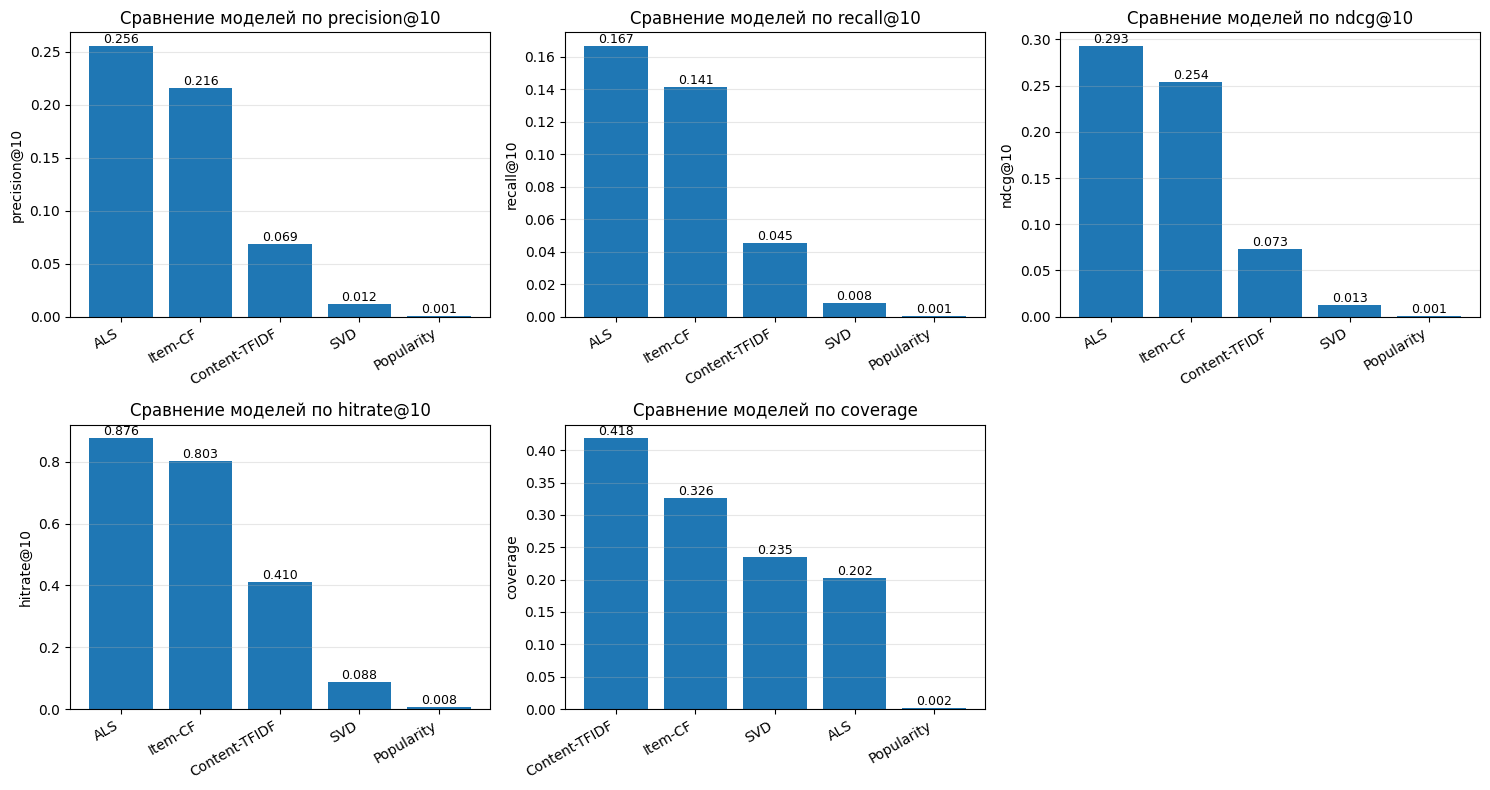

In [32]:
def plot_metrics_bars(df_metrics: pd.DataFrame, k: int = TOP_K):
    metrics = [
        f'precision@{k}',
        f'recall@{k}',
        f'ndcg@{k}',
        f'hitrate@{k}',
        'coverage'
    ]

    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.flatten()

    for i, metric in enumerate(metrics):
        df_plot = df_metrics.sort_values(metric, ascending=False)

        ax = axes[i]
        bars = ax.bar(df_plot['model'], df_plot[metric])

        ax.set_title(f"Сравнение моделей по {metric}")
        ax.set_ylabel(metric)
        ax.tick_params(axis='x', rotation=30)
        ax.set_xticklabels(df_plot['model'], rotation=30, ha='right')
        ax.grid(axis='y', alpha=0.3)

        for bar in bars:
            height = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height,
                f"{height:.3f}",
                ha='center',
                va='bottom',
                fontsize=9
            )

    fig.delaxes(axes[5])

    plt.tight_layout()
    plt.show()

# Вызов
plot_metrics_bars(df_metrics, k=TOP_K)

проверка утечки

In [33]:
def check_seen_items_no_leakage(train_df, test_df):
    """
    Проверка, что seen_items (train) не содержат (user_id, book_id) из test.
    """
    train_pairs = set(zip(train_df['user_id'], train_df['book_id']))
    test_pairs  = set(zip(test_df['user_id'],  test_df['book_id']))

    intersection = train_pairs & test_pairs

    if intersection:
        raise ValueError(
            f" Утечка данных: {len(intersection)} (user_id, book_id) "
            f"присутствуют и в train, и в test"
        )
    else:
        print("Все ок!: seen_items формируются только из train (утечки нет)")

check_seen_items_no_leakage(train_ratings, test_ratings)

Все ок!: seen_items формируются только из train (утечки нет)


###Выводы:

**ALS** показывает наилучшие значения Precision@10, Recall@10, nDCG@10 и HitRate@10. Это указывает на то, что модель хорошо извлекает персонализированные предпочтения пользователей и эффективно ранжирует релевантные книги. Однако при этом покрытие (coverage) у ALS относительно ниже, что говорит о фокусе на ограниченном подмножестве наиболее популярных и релевантных объектов.

**Item**-CF уступает ALS по качеству ранжирования, но демонстрирует более высокое покрытие. Модель хорошо подходит для случаев, когда важны объяснимость рекомендаций и разнообразие, однако по точности персонализации она заметно слабее факторизационных методов.

**Content-TFIDF** обеспечивает наибольшее покрытие каталога, но значительно проигрывает коллаборативным методам по всем метрикам качества. Это ожидаемо, так как контентная модель не использует поведенческие сигналы пользователей и опирается только на текстовые признаки.

**SVD** и Pop**u**larity показали наихудшие результаты. Popularity практически не решает задачу персонализации, а SVD в данной постановке не смог эффективно ранжировать релевантные объекты в top-K.

###Итог:

Различные подходы ведут себя по-разному и решают разные задачи. Среди базовых моделей наиболее эффективной является ALS, при этом Item-CF и Content-based модели выполняют вспомогательные роли (разнообразие, холодный старт), но не конкурируют с ALS по качеству.

### Предложения по развитию проекта

Чтобы улучшить качество модели, нужно использовать сильные стороны каждого подхода и комбинировать модели: Новые пользователи: Popularity (глобальный топ). Новые книги: Content-Based по тегам и описанию. для известных: SVD/ALS или Item-CF

Для построения гибридной модели дополнительно можно использовать:

Текстовые эмбеддинги: заменить TF-IDF на Word2Vec, FastText, или BERT-эмбеддинги описаний книг → лучше улавливают смысл, синонимы и жанровые связи.

Пользовательские фичи: добавить возраст, язык, активность, любимые жанры → можно обучить LightFM, Neural CF, или двусторонний Transformer.

Нейросетевые подходы: Neural Collaborative Filtering (NCF, NeuMF)

# **Итоговый проект: разработка гибридной системы рекомендаций книг**

##План

###Расширенные признаки

Все признаки строятся только по обучающей выборке (train).

•	**Признаки пользователей**: средний рейтинг и количество оценок, отражающие уровень активности. Используются для сегментации пользователей (новые / активные) и взвешивания рекомендаций.

•	**Признаки книг**: популярность, средний рейтинг, разнообразие оценок, тематические признаки из метаданных и текстовых описаний (TF-IDF).

•	**Признаки взаимодействий**: модельные сигналы, описывающие схожесть кандидата с историей пользователя и считающиеся на лету для кандидатов: контентная схожесть (Content-based), скор Item-CF и SVD (предсказанный рейтинг).


###Гибридная система

Двухэтапная архитектура

**Генерация кандидатов (Candidate Generation)**.

Для каждого пользователя объединяем рекомендации от  базовых моделей (Popularity, Content, Item-CF, ALS) в общий пул. Исключаем уже прочитанные книги (seen_items). Т.о. сокращаем пространство поиска, но сохраняем баланс между релевантностью и разнообразием.

**Ранжирование (Rerank).**

Для каждого кандидата вычисляем нормированные скоринговые признаки от базовых моделей.

Итоговый скор  = взвешенная сумма этих признаков.

Веса зависят от типа пользователя: для новых  - больший вклад популярности и контента, для активных — коллаборативные модели и ALS. Используем линейный ансамбль.


###Оценка и оптимизация

Качество оцениваем так же, как в первой -  с использованием метрик (Precision@K, Recall@K, nDCG@K, HitRate@K, Coverage).

Веса подбираем по валидационной выборке из train (per-user), фиксируем и оцениваем на test. Сравниваем гибридную систему с отдельными моделями для разных сегментов пользователей.


###Дальнейшее развитие

Заменяем линейный ансамбль в архитектуре (candidate generation – rerank) на нейросетевой ранжировщик



In [34]:
# Вспомогательная функция: split train = train_fit/val
def split_by_user(df, train_ratio=0.9, random_state=42):
    rng = np.random.default_rng(random_state)
    train_parts, test_parts = [], []
    for uid, g in df.groupby('user_id', sort=False):
        idx = np.arange(len(g))
        rng.shuffle(idx)
        g = g.iloc[idx].reset_index(drop=True)
        n_train = max(1, int(len(g) * train_ratio))
        train_parts.append(g.iloc[:n_train])
        test_parts.append(g.iloc[n_train:])
    return pd.concat(train_parts, ignore_index=True), pd.concat(test_parts, ignore_index=True)


def check_no_leakage(train_df, test_df):
    train_pairs = set(zip(train_df['user_id'], train_df['book_id']))
    test_pairs  = set(zip(test_df['user_id'],  test_df['book_id']))
    inter = train_pairs & test_pairs
    if inter:
        raise ValueError(f"Leakage: {len(inter)} (user_id, book_id) pairs in both train and test.")
    print(" Leakage check passed (train/test пары не пересекаются).")


##Расширенные признаки

In [35]:
def build_user_item_features(train_df):
    # user: mean rating + count (активность)
    u = train_df.groupby('user_id')['rating'].agg(['mean', 'count'])
    user_mean = u['mean'].to_dict()
    user_cnt  = u['count'].to_dict()

    # item: mean rating + count (популярность)
    i = train_df.groupby('book_id')['rating'].agg(['mean', 'count'])
    item_mean = i['mean'].to_dict()
    item_cnt  = i['count'].to_dict()

    return user_mean, user_cnt, item_mean, item_cnt


def build_seen_dict(train_df):
    return train_df.groupby('user_id')['book_id'].apply(set).to_dict()

## Генерация кандидатов

In [36]:
def generate_candidates(user_id, seen_items, per_model_k=200):
    """
    SVD не используется (дорого для генерации).
    """
    cands = set()
    cands.update(als_rec.recommend(user_id, seen_items=seen_items, k=per_model_k))
    cands.update(icf_rec.recommend(user_id, seen_items=seen_items, k=per_model_k))
    cands.update(cb_rec.recommend(user_id, seen_items=seen_items, k=per_model_k))
    cands.update(pop_rec.recommend(user_id, seen_items=seen_items, k=per_model_k))

    cands.difference_update(seen_items)
    return list(cands)

##Скорринговые признаки

In [37]:
def safe_svd_score(user_id, book_id):
    # SVD как рейтинговый предиктор (для кандидатов)
    return float(svd_rec.model.predict(user_id, book_id).est)

def safe_als_score(user_id, book_id):
    # ALS interest-score
    if hasattr(als_rec, "interest_score"):
        return float(als_rec.interest_score(user_id, book_id))
    return np.nan

def safe_content_score(user_id, book_id):
    hist = getattr(cb_rec, "train_by_user", {}).get(user_id)
    if not hist:
        return np.nan

    rows, weights = [], []
    for bid, r in hist:
        row = cb_rec.book_id_to_row.get(bid)
        if row is None:
            continue
        rows.append(row)
        weights.append(float(r))

    if not rows:
        return np.nan

    X = cb_rec.X  # sparse (n_books, n_features)

    # user_vec: (1, n_features) sparse
    w = np.array(weights).reshape(-1, 1)
    user_vec = X[rows].multiply(w).sum(axis=0)
    user_vec = csr_matrix(user_vec)  # гарантируем sparse

    row = cb_rec.book_id_to_row.get(book_id)
    if row is None:
        return np.nan

    item_vec = X[row]  # sparse row (1, n_features)

    # cosine для L2-нормированных TF-IDF: dot(u, v)
    s = user_vec.dot(item_vec.T)  # (1,1) sparse/np-matrix
    # извлекаем число без .toarray()
    if hasattr(s, "A"):
        return float(s.A[0, 0])
    return float(s[0, 0])


In [38]:
def build_candidate_features(
    user_id,
    candidates,
    user_mean, user_cnt,
    item_mean, item_cnt,
    als_top=300,      # ALS кандидаты для score
    icf_top=200       # ICF кандидаты для score
):
    als_score = {} # ALS score map
    try:
        uidx = als_rec.u2i.get(user_id) if hasattr(als_rec, "u2i") else None
        if uidx is not None and hasattr(als_rec, "model") and hasattr(als_rec, "user_item"):
            ids, scores = als_rec.model.recommend(
                uidx,
                als_rec.user_item,
                N=als_top,
                filter_already_liked_items=True,
                return_scores=True
            )
            # ids — item индексы переводим в book_id через als_rec.items
            if hasattr(als_rec, "items"):
                # массив book_id по индексу item
                for iid, s in zip(ids, scores):
                    als_score[int(als_rec.items[iid])] = float(s)
            else:
                # ids как book_id
                for iid, s in zip(ids, scores):
                    als_score[int(iid)] = float(s)
        else:
            # fallback = ранжированный список
            ranked = als_rec.recommend(user_id, seen_items=set(), k=als_top)
            als_score = {int(b): 1.0 / (1 + i) for i, b in enumerate(ranked)}
    except Exception:
        # fallback = позиционный
        try:
            ranked = als_rec.recommend(user_id, seen_items=set(), k=als_top)
            als_score = {int(b): 1.0 / (1 + i) for i, b in enumerate(ranked)}
        except Exception:
            als_score = {}

    # Item-CF positional score map
    try:
        icf_ranked = icf_rec.recommend(user_id, seen_items=set(), k=icf_top)
        icf_score = {int(b): 1.0 / (1 + i) for i, b in enumerate(icf_ranked)}
    except Exception:
        icf_score = {}

    rows = []
    for b in candidates:
        b = int(b)
        rows.append({
            "book_id": b,

            # агрегаты (train)
            "user_cnt": float(user_cnt.get(user_id, 0)),
            "item_cnt": float(item_cnt.get(b, 0)),

            # модельные сигналы для rerank
            "als_s": float(als_score.get(b, 0.0)),
            "icf_s": float(icf_score.get(b, 0.0)),
        })

    df = pd.DataFrame(rows)

    # нормализация скорингов
    for col in ["als_s", "icf_s", "item_cnt"]:
        x = df[col].to_numpy()
        if np.isfinite(x).any():
            scaler = MinMaxScaler((0, 1))
            df[col] = scaler.fit_transform(x.reshape(-1, 1)).ravel()
        else:
            df[col] = 0.0

    return df


## Гибридные рекомендации (взвешенное объединение + сегментация)

In [39]:
class HybridRecommender(BaseRecommender):
    """
    Two-stage hybrid:
    1) Candidate generation: ALS + Item-CF + Content + Popularity
    2) Rerank: weighted sum of normalized model scores
       + optional segmentation by user activity (user_cnt)
    """
    def __init__(
        self,
        user_mean, user_cnt, item_mean, item_cnt,
        weights_active=None,
        weights_cold=None,
        cold_user_cnt_threshold=5,
        per_model_k=100,
        neural_reranker=None      # для нейросети
    ):
        self.user_mean = user_mean
        self.user_cnt  = user_cnt
        self.item_mean = item_mean
        self.item_cnt  = item_cnt

        # веса для активных пользователей
        self.weights_active = weights_active or {"als_s": 0.7, "icf_s": 0.2, "item_cnt": 0.1}
        # веса для новых/малоактивных
        self.weights_cold   = weights_cold   or {"als_s": 0.3, "icf_s": 0.2, "item_cnt": 0.5}

        self.cold_user_cnt_threshold = cold_user_cnt_threshold
        self.per_model_k = per_model_k

        self.neural_reranker = neural_reranker  # для нейросети

    def fit(self, train_df: pd.DataFrame):
        # базовые модели обучаются вне класса, снаружи.
        return self

    def _pick_weights(self, user_id):
        cnt = self.user_cnt.get(user_id, 0)
        return self.weights_cold if cnt < self.cold_user_cnt_threshold else self.weights_active

    def recommend(self, user_id, seen_items, k=TOP_K):
        cands = generate_candidates(user_id, seen_items, per_model_k=self.per_model_k)
        if not cands:
            return pop_rec.recommend(user_id, seen_items=seen_items, k=k)

        feats = build_candidate_features(
            user_id, cands,
            self.user_mean, self.user_cnt,
            self.item_mean, self.item_cnt
        )

        #  если нейросеть вернула скор — используем его как final_score
        if self.neural_reranker is not None and getattr(self.neural_reranker, "is_fitted", False):
            nn_scores = self.neural_reranker.score(feats)
            if nn_scores is not None:
                feats["final_score"] = nn_scores
                return feats.sort_values("final_score", ascending=False)["book_id"].head(k).tolist()

        #  иначе — обычный линейный ансамбль
        w = self._pick_weights(user_id)
        feats["final_score"] = (
            w["als_s"]    * feats["als_s"] +
            w["icf_s"]    * feats["icf_s"] +
            w["item_cnt"] * feats["item_cnt"]
        )

        feats = feats.sort_values("final_score", ascending=False)
        return feats["book_id"].head(k).tolist()

## Подбор весов (val), финальная оценка (test)

In [40]:
def weight_grid():
    return [
        ({"als_s": 0.8, "icf_s": 0.1, "item_cnt": 0.1}, {"als_s": 0.3, "icf_s": 0.2, "item_cnt": 0.5}),
        ({"als_s": 0.7, "icf_s": 0.2, "item_cnt": 0.1}, {"als_s": 0.2, "icf_s": 0.3, "item_cnt": 0.5}),
        ({"als_s": 0.6, "icf_s": 0.3, "item_cnt": 0.1}, {"als_s": 0.3, "icf_s": 0.1, "item_cnt": 0.6}),
        ({"als_s": 0.7, "icf_s": 0.1, "item_cnt": 0.2}, {"als_s": 0.3, "icf_s": 0.2, "item_cnt": 0.5}),
    ]


def tune_hybrid_on_val(
    train_fit,
    val_ratings,
    per_model_k=200,
    cold_user_cnt_threshold=5,
    use_svd=True,
    max_users=None,
    log_every=1
):
    all_items_fit = np.sort(train_fit["book_id"].unique()).tolist()
    user_mean, user_cnt, item_mean, item_cnt = build_user_item_features(train_fit)

    # уменьшаем val по пользователям для ускорения подбора весов
    if max_users is not None:
        u = val_ratings["user_id"].unique()
        u = u[:max_users]  # детерминированно
        val_ratings_small = val_ratings[val_ratings["user_id"].isin(u)].copy()
    else:
        val_ratings_small = val_ratings

    grid = weight_grid()
    best = None

    print(f"Grid search: {len(grid)} комбинаций | val users: {val_ratings_small['user_id'].nunique():,}")

    for i, (w_active, w_cold) in enumerate(tqdm(grid, desc="Tuning hybrid"), start=1):
        tqdm.write(f"[{i}/{len(grid)}] start eval...")

        t0 = time.time()
        model = HybridRecommender(
            user_mean=user_mean, user_cnt=user_cnt,
            item_mean=item_mean, item_cnt=item_cnt,
            weights_active=w_active,
            weights_cold=w_cold,
            cold_user_cnt_threshold=cold_user_cnt_threshold,
            per_model_k=per_model_k
        ).fit(train_fit)

        metrics = evaluate_recommender(
            model=model,
            test_df=val_ratings_small,
            train_df=train_fit,
            all_items=all_items_fit,
            k=TOP_K
        )

        score = float(metrics.get(f"ndcg@{TOP_K}", 0.0))
        dt = time.time() - t0

        if best is None or score > best["score"]:
            best = {"score": score, "weights_active": w_active, "weights_cold": w_cold, "metrics": metrics}

        tqdm.write(f"[{i}/{len(grid)}] done in {dt:.1f}s | ndcg={score:.4f} | best={best['score']:.4f}")

    return best

# случайная подвыборка пользователей для ускорения tuning
def sample_val_users(val_ratings, max_users=5000, random_state=42):
    users = val_ratings["user_id"].unique()
    if len(users) <= max_users:
        return val_ratings

    rng = np.random.default_rng(random_state)
    sampled_users = rng.choice(users, size=max_users, replace=False)
    return val_ratings[val_ratings["user_id"].isin(sampled_users)]


## Гибридная система: val >> подбор весов >> test

In [41]:
# Проверка
check_no_leakage(train_ratings, test_ratings)

# train_fit/val
train_fit, val_ratings = split_by_user(train_ratings, train_ratio=0.9, random_state=RANDOM_STATE)
print("train_fit:", train_fit.shape, "val:", val_ratings.shape)

# подбор весов на val
val_ratings_small = sample_val_users(
    val_ratings,
    max_users=300,
    random_state=RANDOM_STATE
)

best = tune_hybrid_on_val(
    train_fit=train_fit,
    val_ratings=val_ratings_small,
    per_model_k=100,
    cold_user_cnt_threshold=5
)

print(" Best on val:")
print("  score (ndcg):", best["score"])
print("  weights_active:", best["weights_active"])
print("  weights_cold:", best["weights_cold"])
print("  val metrics:", best["metrics"])

# финал - обучаемся на полном train_ratings
user_mean, user_cnt, item_mean, item_cnt = build_user_item_features(train_ratings)
hyb_rec = HybridRecommender(
    user_mean=user_mean, user_cnt=user_cnt,
    item_mean=item_mean, item_cnt=item_cnt,
    weights_active=best["weights_active"],
    weights_cold=best["weights_cold"],
    cold_user_cnt_threshold=5,
    per_model_k=100,
).fit(train_ratings)

# оценка на test
all_items_train = np.sort(train_ratings["book_id"].unique()).tolist()
hyb_metrics_test = evaluate_recommender(hyb_rec, test_ratings, train_ratings, all_items_train, k=TOP_K)

print(" Hybrid test metrics:", hyb_metrics_test)


 Leakage check passed (train/test пары не пересекаются).
train_fit: (4260392, 3) val: (499367, 3)
Grid search: 4 комбинаций | val users: 300


Tuning hybrid:   0%|          | 0/4 [00:00<?, ?it/s]

[1/4] start eval...
[1/4] done in 4.9s | ndcg=0.1790 | best=0.1790
[2/4] start eval...
[2/4] done in 4.9s | ndcg=0.1713 | best=0.1790
[3/4] start eval...
[3/4] done in 5.9s | ndcg=0.1677 | best=0.1790
[4/4] start eval...
[4/4] done in 4.9s | ndcg=0.1643 | best=0.1790
 Best on val:
  score (ndcg): 0.17898906028581552
  weights_active: {'als_s': 0.8, 'icf_s': 0.1, 'item_cnt': 0.1}
  weights_cold: {'als_s': 0.3, 'icf_s': 0.2, 'item_cnt': 0.5}
  val metrics: {'precision@10': 0.11204013377926447, 'recall@10': 0.18200344805695992, 'ndcg@10': 0.17898906028581552, 'hitrate@10': 0.68561872909699, 'coverage': 0.0608}
 Hybrid test metrics: {'precision@10': 0.24186172904293424, 'recall@10': 0.1582016387504126, 'ndcg@10': 0.28387342754870415, 'hitrate@10': 0.8689443205457373, 'coverage': 0.2202}


##Сегментный анализ

In [42]:
def get_segments(train_df, thr=20):
    cnt = train_df.groupby("user_id").size()
    cold = set(cnt[cnt < thr].index)
    active = set(cnt[cnt >= thr].index)
    return cold, active

def eval_segment(models, seg_users, seg_name, test_df, train_df, all_items, k=TOP_K, max_users=500, seed=42):
    # берём только тех пользователей сегмента, которые реально есть в test
    test_users = np.array(sorted(set(test_df["user_id"].unique()) & set(seg_users)))
    if len(test_users) == 0:
        print(f"Skip segment '{seg_name}' (0 users in test)")
        return pd.DataFrame()

    # подвыборка пользователей для ускорения
    rng = np.random.default_rng(seed)
    if len(test_users) > max_users:
        test_users = rng.choice(test_users, size=max_users, replace=False)

    test_seg = test_df[test_df["user_id"].isin(test_users)]

    rows = []
    print(f"\nSegment '{seg_name}': users={len(test_users):,}, test_rows={len(test_seg):,}")
    for name, model in models.items():
        m = evaluate_recommender(model, test_seg, train_df, all_items, k=k)
        rows.append({"segment": seg_name, "model": name, **m})

    return pd.DataFrame(rows)

# сегментный анализ на подвыборке
COLD_THR = 20
MAX_USERS_PER_SEG = 500

cold_users, active_users = get_segments(train_ratings, thr=COLD_THR)
print(f"cold users (train): {len(cold_users):,} | active users (train): {len(active_users):,}")

models = {
    "ALS": als_rec,
    "Item-CF": icf_rec,
    "Hybrid": hyb_rec,
    "Content-TFIDF": cb_rec,
}

df_cold = eval_segment(models, cold_users, "cold", test_ratings, train_ratings, all_items_train,
                       k=TOP_K, max_users=MAX_USERS_PER_SEG, seed=RANDOM_STATE)

df_active = eval_segment(models, active_users, "active", test_ratings, train_ratings, all_items_train,
                         k=TOP_K, max_users=MAX_USERS_PER_SEG, seed=RANDOM_STATE)

df_seg = pd.concat([df_cold, df_active], ignore_index=True)

cols = ["segment", "model", f"precision@{TOP_K}", f"recall@{TOP_K}", f"ndcg@{TOP_K}", f"hitrate@{TOP_K}", "coverage"]
cols = [c for c in cols if c in df_seg.columns]

df_seg[cols].sort_values(["segment", f"ndcg@{TOP_K}"], ascending=[True, False]).reset_index(drop=True)


cold users (train): 34 | active users (train): 53,390

Segment 'cold': users=34, test_rows=168

Segment 'active': users=500, test_rows=11,336


,segment,model,precision@10,recall@10,ndcg@10,hitrate@10,coverage
0,active,ALS,0.254509,0.160845,0.287537,0.871743,0.0951
1,active,Hybrid,0.239279,0.150692,0.277880,0.861723,0.0795
2,active,Item-CF,0.218236,0.138282,0.258101,0.793587,0.0782
3,active,Content-TFIDF,0.067134,0.043503,0.071404,0.414830,0.1014
4,cold,Item-CF,0.120588,0.362745,0.302732,0.794118,0.0073
5,cold,Hybrid,0.091176,0.269118,0.205076,0.676471,0.0078
6,cold,ALS,0.079412,0.231373,0.184864,0.588235,0.0076
7,cold,Content-TFIDF,0.050000,0.164216,0.098664,0.382353,0.0093


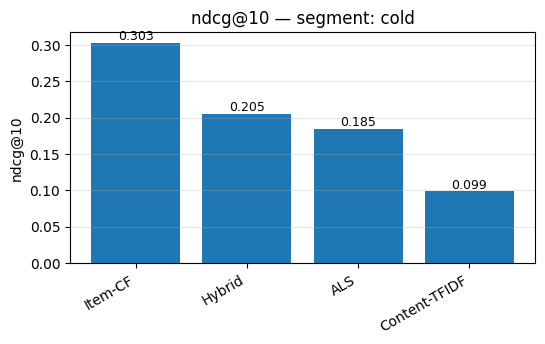

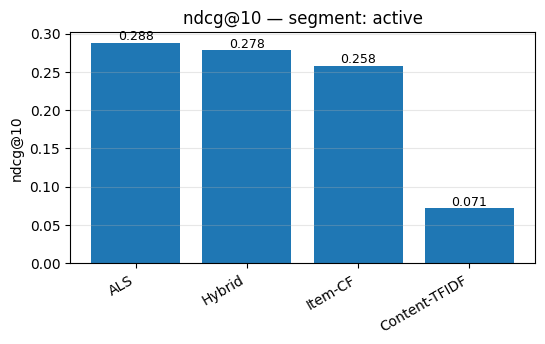

In [43]:
def plot_seg_metric(df, metric):
    for seg in df["segment"].unique():
        d = df[df["segment"] == seg].sort_values(metric, ascending=False)

        plt.figure(figsize=(6, 3))
        bars = plt.bar(d["model"], d[metric])
        plt.title(f"{metric} — segment: {seg}")
        plt.ylabel(metric)
        plt.xticks(rotation=30, ha="right")
        plt.grid(axis="y", alpha=0.3)

        for bar in bars:
            h = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, h, f"{h:.3f}", ha="center", va="bottom", fontsize=9)

        plt.show()

plot_seg_metric(df_seg, metric=f"ndcg@{TOP_K}")


In [44]:
# добавляем гибрид в общую таблицу
hyb_row = {
    "model": "Hybrid",
    **hyb_metrics_test
}

df_compare = pd.concat(
    [df_metrics, pd.DataFrame([hyb_row])],
    ignore_index=True
)

cols = [
    "model",
    "precision@10",
    "recall@10",
    "ndcg@10",
    "hitrate@10",
    "coverage",
]

df_compare[cols].sort_values("ndcg@10", ascending=False).reset_index(drop=True)


,model,precision@10,recall@10,ndcg@10,hitrate@10,coverage
0,ALS,0.255623,0.166547,0.293081,0.876066,0.2020
1,Hybrid,0.241862,0.158202,0.283873,0.868944,0.2202
2,Item-CF,0.215769,0.141036,0.253661,0.802601,0.3258
3,Content-TFIDF,0.068599,0.045043,0.072716,0.410446,0.4182
4,SVD,0.011565,0.008331,0.012515,0.088214,0.2350
5,Popularity,0.000990,0.000665,0.001113,0.008152,0.0019


/tmp/ipython-input-409304980.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_plot['model'], rotation=30, ha='right')
/tmp/ipython-input-409304980.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_plot['model'], rotation=30, ha='right')
/tmp/ipython-input-409304980.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_plot['model'], rotation=30, ha='right')
/tmp/ipython-input-409304980.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_plot['model'], rotation=30, ha='right')
/tmp/ipython-input-409304980.py:22: UserWarning: set_ticklabels() should only be used wi

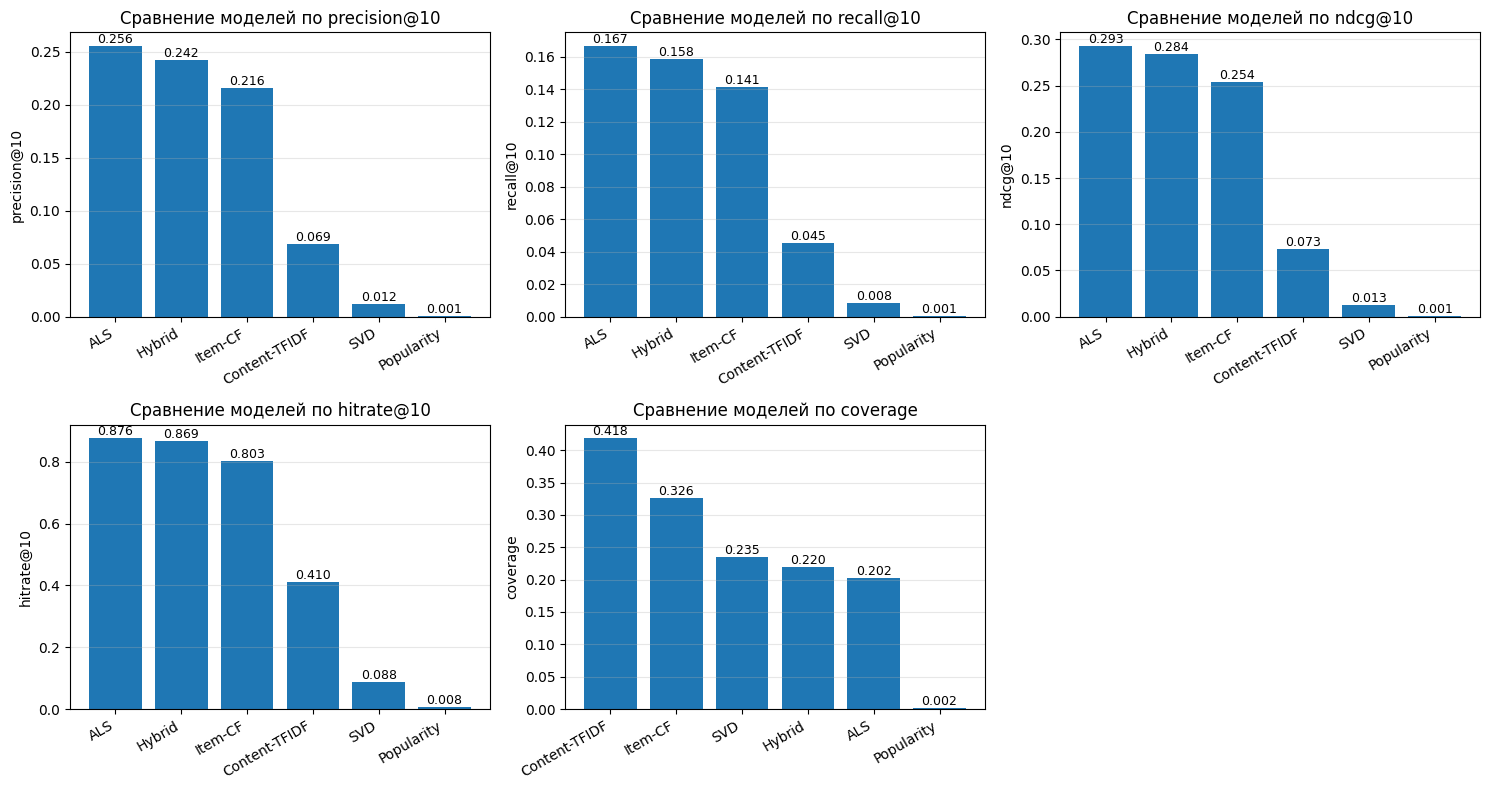

In [45]:
plot_metrics_bars(df_compare, k=TOP_K)

### **Выводы**:

Гибридная система построена как двухэтапная модель:
на первом этапе формируются кандидаты (ALS, Item-CF, Content-based, Popularity),
на втором — выполняется rerank с помощью взвешенного объединения сигналов и сегментации пользователей по активности.

**Активные пользователи**

Для активных пользователей лидером по всем основным метрикам остаётся **ALS**.
Гибридная модель занимает второе место и лишь незначительно уступает ALS по Precision@10, Recall@10 и nDCG@10.

Это говорит о том, что:

ALS максимально эффективно использует богатую историю взаимодействий;

гибридная модель немного теряет в точности из-за добавления дополнительных сигналов, но остаётся близкой к лучшему результату;

Item-CF и Content-based модели существенно проигрывают по качеству персонализации.

Вывод: для активных пользователей гибрид не превосходит ALS, но обеспечивает более устойчивое поведение за счёт комбинирования сигналов.

**Пользователи с низкой активностью (cold)**

Сегмент холодных пользователей в данном эксперименте небольшой и результат нельзя однозначно интерпритировать.

Но на этом сегменте Item-CF показал наилучшее значение nDCG@10, за ним следует Hybrid, затем ALS.
Это указывает на то, что при недостатке пользовательской истории локальные коллаборативные сигналы (похожие объекты) могут работать стабильнее, чем латентные факторные модели.

Гибридная модель не становится лучшей, но демонстрирует более сбалансированное качество по сравнению с ALS, не проваливаясь на холодных пользователях.

Таким образом гибридная модель выполняет роль компромисса между точностью и устойчивостью, снижая риск деградации качества.

###**Итог**

Хотя гибридная модель в данном случае не обогнала все базовые по метрикам, но ее основное преимущество - универсальность

Следует также отметить, что веса гибридной модели подбирались на ограниченной валидационной подвыборке пользователей (val_ratings_small), использованной для ускорения экспериментов.

Гибридная система близка к ALS по качеству для активных пользователей и стабильнее ведёт себя на холодных сегментах. Кроме того она сочетает персонализацию и покрытие каталога. ;

Т.о. гибридный подход оправдан не как способ максимизировать одну метрику, а как практическое решение для рекомендательной системы, где нам важны и устойчивость, и масштабируемость и работа с разными типами пользователей.

##Добавление нейросетевого подхода.

Добавляем **нейросетевой** **ранжировщик** по признакам. Встраиваем нейросеть как замену инейного взвешивания на этапе rerank, что позволяет архитектура  two-stage (candidate generation - rerank)

In [46]:
# Нейросетевой ранжировщик
class NeuralReranker:
    """
    Нейросетевой ранжировщик для rerank кандидатов.
    Обучаемся на val: positives = rating>=RELEVANCE_THRESHOLD, negatives = остальные кандидаты.
    Используем те же признаки, что и гибрид: als_s, icf_s, item_cnt.
    """
    def __init__(self, epochs=3, batch_size=4096, lr=1e-3):
        self.epochs = epochs
        self.batch_size = batch_size
        self.lr = lr
        self.is_fitted = False
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        self.model = nn.Sequential(
            nn.Linear(3, 32), nn.ReLU(),
            nn.Linear(32, 32), nn.ReLU(),
            nn.Linear(32, 1)
        ).to(self.device)

    def fit(
        self,
        train_fit: pd.DataFrame,
        val_ratings: pd.DataFrame,
        feature_builder,
        user_mean: dict,
        user_cnt: dict,
        item_mean: dict,
        item_cnt: dict,
        per_model_k: int = 100,
        neg_per_pos: int = 3,
        log_step_pct: int = 10,
    ):
        print("NeuralReranker: start training")
        print(f"   device: {self.device}")
        print(f"   epochs={self.epochs}, batch_size={self.batch_size}, lr={self.lr}")

        seen = build_seen_dict(train_fit)

        # positives на val
        val_pos = (
            val_ratings[val_ratings["rating"] >= RELEVANCE_THRESHOLD]
            .groupby("user_id")["book_id"]
            .apply(set)
            .to_dict()
        )

        total_users = len(val_pos)
        print(f"   users with positives in val: {total_users:,}")

        X_rows, y_rows = [], []
        feat_cols = ["als_s", "icf_s", "item_cnt"]

        # сбор обучающих примеров
        processed = 0
        last_pct = -1

        for uid, pos_items in val_pos.items():
            processed += 1
            if total_users > 0:
                pct = int(100 * processed / total_users)
                if log_step_pct and (pct % log_step_pct == 0) and (pct != last_pct):
                    print(f"   building train pairs: {pct}%")
                    last_pct = pct

            seen_items = seen.get(uid, set())

            # кандидаты на основе базовых моделей (как в гибриде)
            cands = generate_candidates(uid, seen_items, per_model_k=per_model_k)
            if not cands:
                continue

            cset = set(map(int, cands))
            pos_in = list(cset & set(map(int, pos_items)))
            if not pos_in:
                continue

            neg_pool = list(cset - set(pos_in))
            if not neg_pool:
                continue

            # признаки кандидатов (те же, что в гибриде)
            feats = (
                feature_builder(
                    uid, list(cset),
                    user_mean, user_cnt,
                    item_mean, item_cnt
                )
                .set_index("book_id")
            )

            for b in pos_in:
                b = int(b)
                if b not in feats.index:
                    continue

                X_rows.append(feats.loc[b, feat_cols].to_numpy(dtype=np.float32))
                y_rows.append(1.0)

                m = min(neg_per_pos, len(neg_pool))
                if m <= 0:
                    continue

                negs = np.random.choice(neg_pool, size=m, replace=False)
                for nb in negs:
                    nb = int(nb)
                    if nb not in feats.index:
                        continue
                    X_rows.append(feats.loc[nb, feat_cols].to_numpy(dtype=np.float32))
                    y_rows.append(0.0)

        X = np.asarray(X_rows, dtype=np.float32)
        y = np.asarray(y_rows, dtype=np.float32)

        print(f"   training pairs: {len(X):,}")
        if len(X) == 0:
            raise ValueError("Не удалось собрать обучающие примеры для reranker (X пуст).")

        # обучение MLP
        ds = TensorDataset(torch.tensor(X), torch.tensor(y))
        dl = DataLoader(ds, batch_size=self.batch_size, shuffle=True)

        opt = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        loss_fn = nn.BCEWithLogitsLoss()

        self.model.train()
        for ep in range(1, self.epochs + 1):
            total, n = 0.0, 0
            for xb, yb in dl:
                xb = xb.to(self.device).float()
                yb = yb.to(self.device).float()

                opt.zero_grad()
                logits = self.model(xb).squeeze(-1)
                loss = loss_fn(logits, yb)
                loss.backward()
                opt.step()

                total += float(loss.item()) * xb.size(0)
                n += xb.size(0)

            print(f"   epoch [{ep}/{self.epochs}] | loss={total/max(1,n):.5f}")

        self.is_fitted = True
        print(" NeuralReranker: training finished\n")
        return self

    @torch.no_grad()
    def score(self, feats_df: pd.DataFrame) -> np.ndarray:
        if not self.is_fitted:
            return None

        X = feats_df[["als_s", "icf_s", "item_cnt"]].to_numpy(dtype=np.float32)
        xb = torch.tensor(X, device=self.device).float()

        self.model.eval()
        logits = self.model(xb).squeeze(-1).detach().cpu().numpy()
        return logits


Нейросетевой ранжировщик обучаем на той же валидационной подвыборке пользователей, что и подбор весов гибридной модели.

In [47]:
# обучаем нейросеть
user_mean, user_cnt, item_mean, item_cnt = build_user_item_features(train_fit)   # агрегаты признаков

print("Train neural reranker (on val subset)")
nn_reranker = NeuralReranker(epochs=3).fit(
    train_fit=train_fit,
    val_ratings=val_ratings_small,          # не весь val
    feature_builder=build_candidate_features,
    user_mean=user_mean,
    user_cnt=user_cnt,
    item_mean=item_mean,
    item_cnt=item_cnt,
    per_model_k=100
)

print("Build hybrid model with neural reranker")
hyb_nn = HybridRecommender(
    user_mean=user_mean,
    user_cnt=user_cnt,
    item_mean=item_mean,
    item_cnt=item_cnt,
    weights_active=best["weights_active"],
    weights_cold=best["weights_cold"],
    cold_user_cnt_threshold=5,
    per_model_k=100,
    neural_reranker=nn_reranker
).fit(train_ratings)

print("Evaluate hybrid + neural")
hyb_nn_metrics = evaluate_recommender(
    hyb_nn,
    test_ratings,
    train_ratings,
    all_items_train,
    k=TOP_K
)

print("Hybrid + Neural metrics:", hyb_nn_metrics)

Train neural reranker (on val subset)
NeuralReranker: start training
   device: cuda
   epochs=3, batch_size=4096, lr=0.001
   users with positives in val: 299
   building train pairs: 0%
   building train pairs: 10%
   building train pairs: 20%
   building train pairs: 30%
   building train pairs: 40%
   building train pairs: 50%
   building train pairs: 60%
   building train pairs: 70%
   building train pairs: 80%
   building train pairs: 90%
   building train pairs: 100%
   training pairs: 5,248
   epoch [1/3] | loss=0.69835
   epoch [2/3] | loss=0.68998
   epoch [3/3] | loss=0.68165
 NeuralReranker: training finished

Build hybrid model with neural reranker
Evaluate hybrid + neural
Hybrid + Neural metrics: {'precision@10': 0.2210929740063045, 'recall@10': 0.1456934531282873, 'ndcg@10': 0.2644678569707581, 'hitrate@10': 0.8420322719691149, 'coverage': 0.463}


/tmp/ipython-input-409304980.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_plot['model'], rotation=30, ha='right')
/tmp/ipython-input-409304980.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_plot['model'], rotation=30, ha='right')
/tmp/ipython-input-409304980.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_plot['model'], rotation=30, ha='right')
/tmp/ipython-input-409304980.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_plot['model'], rotation=30, ha='right')
/tmp/ipython-input-409304980.py:22: UserWarning: set_ticklabels() should only be used wi

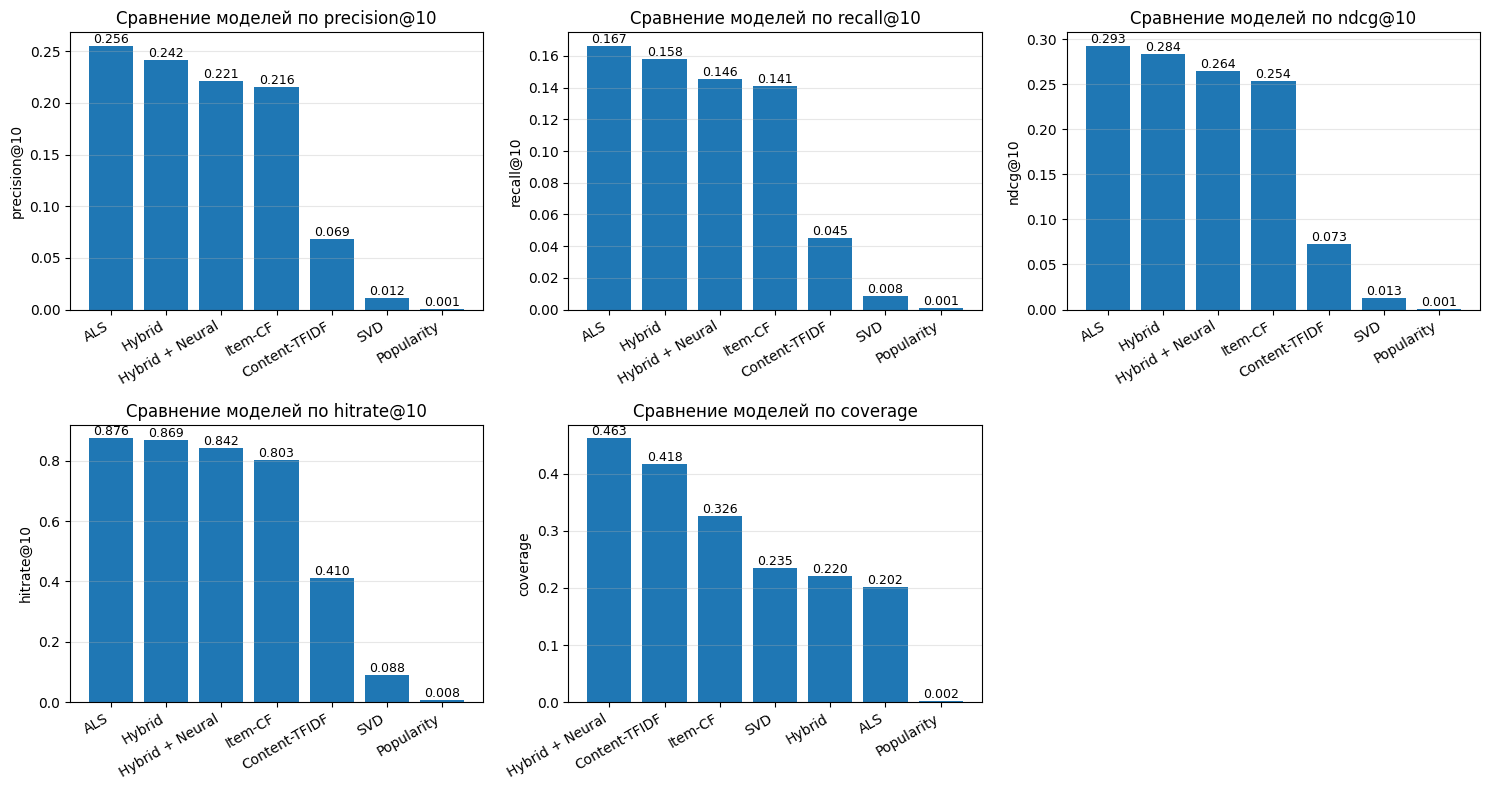

In [48]:
# добавляем Hybrid + Neural
hyb_nn_row = {
    "model": "Hybrid + Neural",
    **hyb_nn_metrics
}

# общая таблица
df_compare = pd.concat(
    [df_metrics, pd.DataFrame([hyb_row, hyb_nn_row])],
    ignore_index=True
)
cols = [
    "model",
    f"precision@{TOP_K}",
    f"recall@{TOP_K}",
    f"ndcg@{TOP_K}",
    f"hitrate@{TOP_K}",
    "coverage",
]

df_compare_sorted = (
    df_compare[cols]
    .sort_values(f"ndcg@{TOP_K}", ascending=False)
    .reset_index(drop=True)
)

df_compare_sorted
plot_metrics_bars(df_compare_sorted, k=TOP_K)

In [49]:
df_compare[cols].sort_values("ndcg@10", ascending=False).reset_index(drop=True)

,model,precision@10,recall@10,ndcg@10,hitrate@10,coverage
0,ALS,0.255623,0.166547,0.293081,0.876066,0.2020
1,Hybrid,0.241862,0.158202,0.283873,0.868944,0.2202
2,Hybrid + Neural,0.221093,0.145693,0.264468,0.842032,0.4630
3,Item-CF,0.215769,0.141036,0.253661,0.802601,0.3258
4,Content-TFIDF,0.068599,0.045043,0.072716,0.410446,0.4182
5,SVD,0.011565,0.008331,0.012515,0.088214,0.2350
6,Popularity,0.000990,0.000665,0.001113,0.008152,0.0019


Нейросетевой ранжировщик интегрирован в существующую гибридную систему рекомендаций. Нейросеть использует те же признаки, что и линейный гибрид (ALS-score, Item-CF-score, популярность), и обучается на той же валидационной подвыборке пользователей.

Добавление нейросетевого ранжировщика не привело к улучшению качества рекомендаций по сравнению с оптимизированной линейной гибридной моделью. Это связано с ограниченным объёмом обучающих данных для нейросети и простым набором признаков, не содержащим дополнительных нелинейных или семантических сигналов.

Используемый в работе набор признаков является упрощённым и состоит в основном из агрегированных статистик и скорингов классических моделей (ALS и Item-CF). Такой набор признаков хорошо подходит для линейного гибридного ранжирования, но для нейросетевой модели не дает дополнительных нелинейных или семантических сигналов. Для эффективного применения нейросетевых методов необходимо более "богатое" пространство признаков.